In [29]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

### Filtering the raw data

In [9]:
df = pd.read_csv("bank-full.csv", delimiter = ";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [10]:
df.columns 

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [11]:
cols = ['age', 'job', 'marital', 'education', 'balance', 'housing',
       'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y']

df = df[cols]
df.columns

Index(['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact',
       'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome',
       'y'],
      dtype='object')

In [12]:
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state= 1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state= 1)


#### Question 1: ROC AUC feature importance

In [13]:
numerical = list(df_full_train.columns[(df_full_train.dtypes != object)])
numerical

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [14]:
from sklearn.metrics import roc_auc_score

In [19]:
auc_scores = [round(roc_auc_score(df_train["y"], df_train[num_col]),3) for num_col in numerical]
max_index = auc_scores.index(max(auc_scores))
print(auc_scores)
print(f"The numerical variable with max auc equal to {max(auc_scores)} is {numerical[max_index]}")


[0.488, 0.589, 0.474, 0.815, 0.429, 0.59, 0.599]
The numerical variable with max auc equal to 0.815 is duration


#### Question 2: Training the model

In [23]:
all_variables = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']
dv = DictVectorizer(sparse = False)
train_dict = df_train[all_variables].to_dict(orient = "records")
X_train = dv.fit_transform(train_dict)
y_train = (df_train["y"] != "no").astype("int") 
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dict = df_val[all_variables].to_dict(orient = "records")
X_val = dv.transform(val_dict)
y_val = (df_val["y"] != "no").astype("int") 
y_val_predict = model.predict_proba(X_val)[:,1]

print(f"the AUC on validation set of the model is {round(roc_auc_score(y_val, y_val_predict),3)}")

the AUC on validation set of the model is 0.9


Looking at the options of the question, the correct answer is 0.89

#### Question 3: Precision and Recall

Counter({'no': 7944, 'yes': 1098})


C:\Users\mderkaoui\AppData\Local\Temp\ipykernel_21432\1046382120.py:23: RuntimeWarning: invalid value encountered in scalar divide
  p.append(tp / (tp + fp))


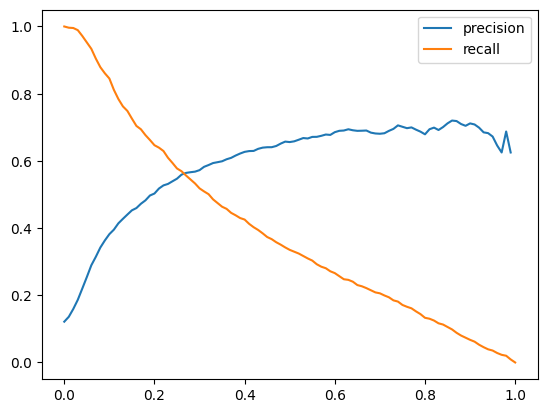

In [41]:
from collections import Counter
print(Counter(df_val["y"]))

step = 0.01
thresholds = np.arange(0, 1 + step, step)

actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

p = []
r = []

for t in thresholds:
    predict_positive = (y_val_predict >= t)
    predict_negative = (y_val_predict < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p.append(tp / (tp + fp))
    r.append(tp / (tp + fn))
plt.plot(thresholds, p, label='precision')
plt.plot(thresholds, r, label='recall')
plt.legend()

Precision and Recall curves intersect for threshold approx to 0.265

#### Question 4: F1 score

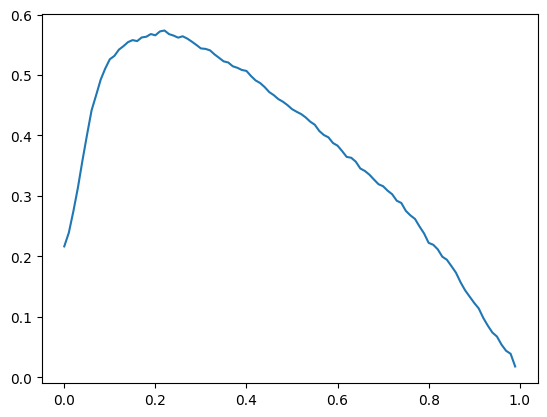

In [42]:
F1 = 2 * np.array(p) * np.array(r) / ( np.array(p) + np.array(r)) 
plt.plot(thresholds, F1, label='F1')

F1 is maximal at threshold t = 0.22

#### Question 5: 5-Fold CV

In [43]:
from sklearn.model_selection import KFold

In [44]:
!pip install tqdm

In [52]:
from tqdm.auto import tqdm

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    train_dict = df_train[all_variables].to_dict(orient = "records")
    X_train = dv.fit_transform(train_dict)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    val_dict = df_val[all_variables].to_dict(orient = "records")
    X_val = dv.transform(val_dict)

    y_pred = model.predict_proba(X_val)[:,1]

    auc_scores.append(roc_auc_score(y_val, y_pred))

print('%.3f' % np.std(auc_scores))


0.006


The standard deviation of the scores across different folds is 0.006

#### Question 6: Hyperparameter Tuning

In [54]:
c_values = [0.000001, 0.001, 1]

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for c in c_values :
    auc_scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        train_dict = df_train[all_variables].to_dict(orient = "records")
        X_train = dv.fit_transform(train_dict)
        
        model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
        model.fit(X_train, y_train)

        val_dict = df_val[all_variables].to_dict(orient = "records")
        X_val = dv.transform(val_dict)

        y_pred = model.predict_proba(X_val)[:,1]

        auc_scores.append(roc_auc_score(y_val, y_pred))

    print('for C=%s  : mean =%.3f and std= %.3f' % (c, np.mean(auc_scores), np.std(auc_scores)))

for C=1e-06  : mean =0.701 and std= 0.009
for C=0.001  : mean =0.861 and std= 0.007
for C=1  : mean =0.906 and std= 0.006


The C that leads to the best mean score is 1